/tmp/ipykernel_998821/3735889393.py:57: UserWarning: Using torch.cross without specifying the dim arg is deprecated.
Please either pass the dim explicitly or simply use torch.linalg.cross.
The default value of dim will change to agree with that of linalg.cross in a future release. (Triggered internally at /pytorch/aten/src/ATen/native/Cross.cpp:62.)
  x_axis = torch.cross(up.to(device), z_axis)


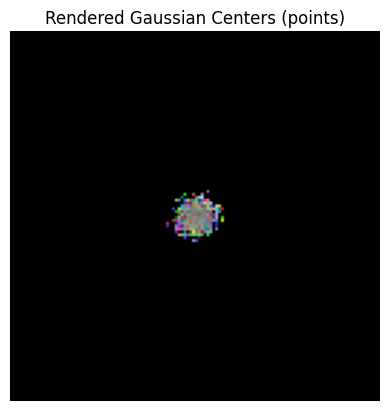

In [ ]:
import torch
import matplotlib.pyplot as plt

def get_camera_intrinsics(W, H, focal):
    return torch.tensor([
        [focal, 0, W / 2],
        [0, focal, H / 2],
        [0, 0, 1]
    ], dtype=torch.float32)

def project_points(points, pose, K):
    N = points.shape[0]
    device = points.device

    points_h = torch.cat([points, torch.ones(N, 1, device=device)], dim=-1)  # (N,4)

    cam_points = (pose @ points_h.T).T[:, :3]  # (N,3)

    z = -cam_points[:, 2]

    fx, fy = K[0, 0], K[1, 1]
    cx, cy = K[0, 2], K[1, 2]

    # Avoid division by zero by clamping z (only for valid points, will handle negative z separately)
    z_safe = z.clamp(min=1e-5)

    u = fx * cam_points[:, 0] / z_safe + cx
    v = fy * cam_points[:, 1] / z_safe + cy

    coords = torch.stack([u, v], dim=-1)

    return coords, z, cam_points

def render_nearest_pixel(points, colors, pose, K, image_size):
    device = points.device
    H, W = image_size, image_size
    canvas = torch.zeros(3, H*W, device=device)
    count = torch.zeros(H*W, device=device)

    coords, _, _ = project_points(points, pose, K)
    x = coords[:, 0].round().long().clamp(0, W - 1)
    y = coords[:, 1].round().long().clamp(0, H - 1)
    idx = y * W + x

    # Accumulate colors and counts
    canvas.index_add_(1, idx, colors.T)
    count.index_add_(0, idx, torch.ones_like(idx, dtype=torch.float32))

    count = count.clamp(min=1.0)
    img = (canvas / count).view(3, H, W).clamp(0, 1)
    return img

def look_at(camera_pos, target, up=torch.tensor([0, 1, 0], dtype=torch.float32)):
    device = camera_pos.device
    z_axis = (camera_pos - target)
    z_axis /= torch.norm(z_axis)
    x_axis = torch.cross(up.to(device), z_axis)
    x_axis /= torch.norm(x_axis)
    y_axis = torch.cross(z_axis, x_axis)

    pose = torch.eye(4, device=device)
    pose[:3, 0] = x_axis
    pose[:3, 1] = y_axis
    pose[:3, 2] = z_axis
    pose[:3, 3] = camera_pos
    return pose

device = 'cuda' if torch.cuda.is_available() else 'cpu'

image_size = 128
N = 1000

xyz = torch.randn(N, 3, device=device) * 0.1  # Cluster near origin
colors = torch.rand(N, 3, device=device)

camera_pos = torch.tensor([2.0, 2.0, 2.0], device=device)
target = torch.tensor([0.0, 0.0, 0.0], device=device)

pose_c2w = look_at(camera_pos, target)
pose_w2c = torch.inverse(pose_c2w)

focal = 100.0

K = get_camera_intrinsics(image_size, image_size, focal).to(device)

img = render_nearest_pixel(xyz, colors, pose_w2c, K, image_size)

plt.imshow(img.permute(1, 2, 0).cpu().numpy())
plt.title("Rendered Gaussian Centers (points)")
plt.axis('off')
plt.show()


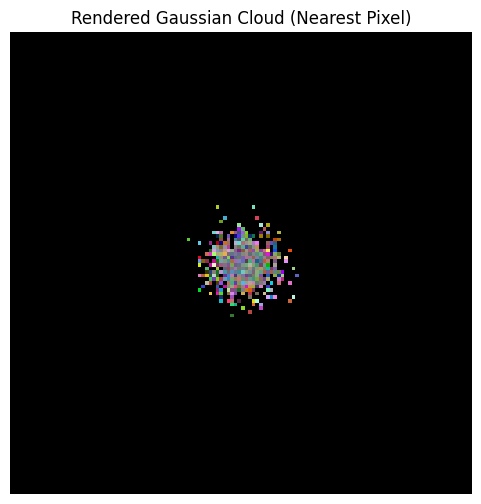

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm
import numpy as np
import imageio.v3 as iio
import json
import os

# === Dataset ===
class NeRFDataset(Dataset):
    def __init__(self, json_path, image_size=128, device='cuda'):
        with open(json_path, 'r') as f:
            meta = json.load(f)

        self.frames = meta['frames']
        self.camera_angle_x = meta['camera_angle_x']
        self.image_size = image_size
        self.device = device
        self.base_dir = os.path.dirname(json_path)
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((image_size, image_size))
        ])

    def __len__(self):
        return len(self.frames)

    def __getitem__(self, idx):
        frame = self.frames[idx]
        img_path = os.path.join(self.base_dir, frame['file_path'] + '.png')

        raw = iio.imread(img_path).astype(np.float32) / 255.0
        if raw.shape[-1] == 4:
            raw = raw[:, :, :3]  # drop alpha
        image = self.transform(raw).to(self.device)

        pose = torch.tensor(frame['transform_matrix'], dtype=torch.float32).to(self.device)
        return image, pose


def get_camera_intrinsics(camera_angle_x, W, H):
    focal = 0.5 * W / np.tan(0.5 * camera_angle_x)
    return torch.tensor([
        [focal, 0, W / 2],
        [0, focal, H / 2],
        [0, 0, 1]
    ], dtype=torch.float32)

def project_points(points, pose, K):
    N = points.shape[0]
    device = points.device
    points_h = torch.cat([points, torch.ones(N, 1, device=device)], dim=-1)  # (N,4)
    cam_points = (pose @ points_h.T).T[:, :3]  # (N,3)

    z = -cam_points[:, 2]

    fx, fy = K[0, 0], K[1, 1]
    cx, cy = K[0, 2], K[1, 2]

    # Avoid division by zero by clamping z (only for valid points, will handle negative z separately)
    z_safe = z.clamp(min=1e-5)

    u = fx * cam_points[:, 0] / z_safe + cx
    v = fy * cam_points[:, 1] / z_safe + cy

    coords = torch.stack([u, v], dim=-1)

    return coords, z, cam_points

def render_nearest_pixel(points, colors, pose, K, image_size):
    device = points.device
    H, W = image_size, image_size
    canvas = torch.zeros(3, H*W, device=device)
    count = torch.zeros(H*W, device=device)

    coords, _, _ = project_points(points, pose, K)
    x = coords[:, 0].round().long().clamp(0, W - 1)
    y = coords[:, 1].round().long().clamp(0, H - 1)
    idx = y * W + x

    # Accumulate colors and counts
    canvas.index_add_(1, idx, colors.T)
    count.index_add_(0, idx, torch.ones_like(idx, dtype=torch.float32))

    count = count.clamp(min=1.0)
    img = (canvas / count).view(3, H, W).clamp(0, 1)
    return img

# Your functions (project_points, get_camera_intrinsics, render_nearest_pixel, NeRFDataset) assumed already defined

device = 'cuda' if torch.cuda.is_available() else 'cpu'
image_size = 128
N_gaussians = 1000

# Load dataset
dataset = NeRFDataset('nerf_synthetic/lego/transforms_train.json', image_size=image_size, device=device)

# Pick one frame (say first)
image, pose_c2w = dataset[0]  # pose is camera-to-world (4x4)
pose_w2c = torch.inverse(pose_c2w)  # world-to-camera

# Camera intrinsics
K = get_camera_intrinsics(dataset.camera_angle_x, image_size, image_size).to(device)

# Generate Gaussian points clustered around origin (world space)
center_xyz = torch.tensor([0.0, 0.0, -0.0], device=device)
gaussians_xyz = center_xyz + (torch.randn(N_gaussians, 3, device=device) * 0.1)
gaussians_color = torch.rand(N_gaussians, 3, device=device)  # random colors

# Render the points using camera pose from dataset
rendered_img = render_nearest_pixel(gaussians_xyz, gaussians_color, pose_w2c, K, image_size)

# Show rendered image
plt.figure(figsize=(6,6))
plt.imshow(rendered_img.permute(1, 2, 0).cpu().numpy())
plt.title("Rendered Gaussian Cloud (Nearest Pixel)")
plt.axis('off')
plt.show()

[INFO] Loading existing SfM reconstruction from temp/sfm_output
[INFO] Number of registered images: 100
[INFO] Number of 3D points: 12313
[CAMERA INFO] Image ID: 100
 - Image name: r_99.png
 - Camera ID: 1
 - Camera model: CameraModelId.PINHOLE
 - Image size: 800 x 800
 - Intrinsic parameters (4): [1103.6899312  1103.61495604  400.          400.        ]
 - cam_from_world:
[[-0.62799559 -0.67440199  0.38833426 -0.37334119]
 [ 0.60756971 -0.11306518  0.78617766 -2.12819661]
 [-0.48629269  0.72965623  0.48075066  2.66994006]]
------------------------------------------------------------
[CAMERA INFO] Image ID: 99
 - Image name: r_97.png
 - Camera ID: 1
 - Camera model: CameraModelId.PINHOLE
 - Image size: 800 x 800
 - Intrinsic parameters (4): [1103.6899312  1103.61495604  400.          400.        ]
 - cam_from_world:
[[ 0.86666036  0.44336217 -0.22875711  0.09149356]
 [-0.28242589  0.81397968  0.50761471 -1.97338265]
 [ 0.4112608  -0.37532261  0.83066087  2.47002224]]
------------------

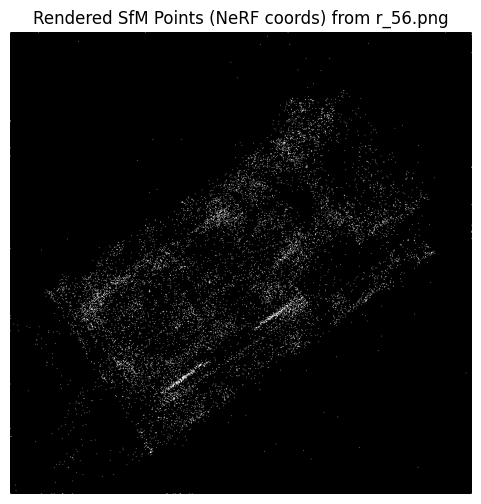

In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm
import numpy as np
import imageio.v3 as iio
import json
import pycolmap
import os
from pathlib import Path
import shutil
from pyquaternion import Quaternion  # pip install pyquaternion

# Define the helper
def to_homogeneous(pose_3x4):
    bottom_row = torch.tensor([[0, 0, 0, 1]], dtype=pose_3x4.dtype, device=pose_3x4.device)
    pose_4x4 = torch.cat([pose_3x4, bottom_row], dim=0)
    return pose_4x4

def colmap_to_nerf_points(points):
    # Same flip to move world into NeRF-style frame where Z-forward = negative
    return points @ torch.diag(torch.tensor([1.0, -1.0, -1.0], dtype=points.dtype, device=points.device)).T

def colmap_to_nerf_pose(pose):
    flip = torch.diag(torch.tensor([1.0, -1.0, -1.0], dtype=pose.dtype, device=pose.device))
    R = pose[:3, :3] @ flip
    t = pose[:3, 3]
    return torch.cat([
        torch.cat([R, t.view(3, 1)], dim=1),
        torch.tensor([[0.0, 0.0, 0.0, 1.0]], dtype=pose.dtype, device=pose.device)
    ], dim=0)

def project_points(points, pose, K):
    N = points.shape[0]
    device = points.device
    points_h = torch.cat([points, torch.ones(N, 1, device=device)], dim=-1)  # (N,4)
    cam_points = (pose @ points_h.T).T[:, :3]  # (N,3)

    z = cam_points[:, 2]

    fx, fy = K[0, 0], K[1, 1]
    cx, cy = K[0, 2], K[1, 2]

    # Avoid division by zero by clamping z (only for valid points, will handle negative z separately)
    z_safe = z.clamp(min=1e-5)

    u = fx * cam_points[:, 0] / z_safe + cx
    v = fy * cam_points[:, 1] / z_safe + cy

    coords = torch.stack([u, v], dim=-1)

    return coords, z, cam_points

def render_nearest_pixel(points, colors, pose, K, image_size):
    device = points.device
    H, W = image_size, image_size
    canvas = torch.zeros(3, H*W, device=device)
    count = torch.zeros(H*W, device=device)

    coords, _, _ = project_points(points, pose, K)
    x = coords[:, 0].round().long().clamp(0, W - 1)
    y = coords[:, 1].round().long().clamp(0, H - 1)
    idx = y * W + x

    # Accumulate colors and counts
    canvas.index_add_(1, idx, colors.T)
    count.index_add_(0, idx, torch.ones_like(idx, dtype=torch.float32))

    count = count.clamp(min=1.0)
    img = (canvas / count).view(3, H, W).clamp(0, 1)
    return img

def sfm_extract(image_dir, device='cuda'):
    """
    Run SfM pipeline using pycolmap Python API, extract camera poses, intrinsics, and 3D points.
    """
    image_dir = Path(image_dir)
    database_path = Path("temp/database.db")
    sfm_path = Path("temp/sfm_output")

    if sfm_path.exists() and any(sfm_path.iterdir()):
        print(f"[INFO] Loading existing SfM reconstruction from {sfm_path}")
        reconstruction = pycolmap.Reconstruction(str(sfm_path / "0"))
    else:
        # Clean up previous runs
        if database_path.exists():
            database_path.unlink()
        if sfm_path.exists():
            shutil.rmtree(sfm_path)
        sfm_path.mkdir(parents=True, exist_ok=True)

        # 1. Extract features
        print("[INFO] Extracting features...")

        pycolmap.extract_features(
            database_path=str(database_path),
            image_path=str(image_dir),
            camera_model='PINHOLE',
            camera_mode='SINGLE'
        )

        # 2. Match features
        print("[INFO] Matching features...")
        pycolmap.match_exhaustive(str(database_path))

        # 3. Incremental mapping
        print("[INFO] Performing incremental mapping...")
        reconstructions = pycolmap.incremental_mapping(
            str(database_path),
            str(image_dir),
            str(sfm_path),
            initial_image_pair_callback=lambda: print("[INFO] Initial image pair registered."),
            next_image_callback=lambda: print("[INFO] Next image registered.")
        )

        if not reconstructions:
            raise RuntimeError("No reconstructions found")
        reconstruction = reconstructions[0]

    print(f"[INFO] Number of registered images: {len(reconstruction.images)}")
    print(f"[INFO] Number of 3D points: {len(reconstruction.points3D)}")

    # Extract camera poses and intrinsics
    pose_c2w_dict = {}
    intrinsics_dict = {}
    camera_models = set()

    for img_id, img in reconstruction.images.items():
        img_name = os.path.basename(img.name)
        pose = torch.tensor(img.cam_from_world.matrix(), dtype=torch.float32, device=device)
        intrinsics = torch.tensor(img.camera.params, dtype=torch.float32, device=device)

        pose_c2w_dict[img_name] = pose
        intrinsics_dict[img_name] = intrinsics

        camera = img.camera
        camera_models.add(camera.model)

        print(f"[CAMERA INFO] Image ID: {img_id}")
        print(f" - Image name: {img.name}")
        print(f" - Camera ID: {camera.camera_id}")
        print(f" - Camera model: {camera.model}")
        print(f" - Image size: {camera.width} x {camera.height}")
        print(f" - Intrinsic parameters ({len(camera.params)}): {camera.params}")
        print(f" - cam_from_world:\n{img.cam_from_world.matrix()}")
        print("-" * 60)

    if len(camera_models) == 1:
        print(f"[INFO] Single camera model detected: {list(camera_models)[0]}")
    else:
        print(f"[WARNING] Multiple camera models detected: {camera_models}")

    # Extract 3D points
    points3D = (
        torch.stack([
            torch.tensor(p.xyz, dtype=torch.float32, device=device)
            for p in reconstruction.points3D.values()
        ])
        if reconstruction.points3D else
        torch.empty((0, 3), device=device)
    )

    return pose_c2w_dict, intrinsics_dict, points3D

def render_colmap_pointcloud(image_dir, target_image_name, image_size=800, device='cuda'):

    # 1. Extract SfM data
    pose_c2w_dict, intrinsics_dict, points3D = sfm_extract(image_dir, device=device)

    # 2. Select camera pose
    assert target_image_name in pose_c2w_dict, f"Camera {target_image_name} not found in SfM data"
    pose_c2w = pose_c2w_dict[target_image_name]

    # 3. Convert pose to homogeneous matrix and inverse
    pose_w2c = to_homogeneous(pose_c2w)
    #pose_w2c = torch.inverse(pose_c2w_h)

    # 4. Transform pose and points into NeRF coord system
    pose_w2c_nerf = colmap_to_nerf_pose(pose_w2c)
    points3D_nerf = colmap_to_nerf_points(points3D)

    # 5. Intrinsics rescaling
    intrinsics_params = intrinsics_dict[target_image_name].cpu().numpy()
    fx, fy, cx, cy = intrinsics_params[:4]

    original_width = 800  # Replace with actual width from COLMAP if needed
    original_height = 800

    scale_x = image_size / original_width
    scale_y = image_size / original_height

    fx *= scale_x
    fy *= scale_y
    cx *= scale_x
    cy *= scale_y

    K = torch.tensor([
        [fx, 0, cx],
        [0, fy, cy],
        [0,  0,  1]
    ], dtype=torch.float32, device=device)

    # 6. Render
    rendered_img = render_nearest_pixel(points3D_nerf, torch.ones_like(points3D_nerf), pose_w2c_nerf, K, image_size)

    # 7. Display
    plt.figure(figsize=(6, 6))
    plt.imshow(rendered_img.permute(1, 2, 0).cpu().numpy())
    plt.title(f"Rendered SfM Points (NeRF coords) from {target_image_name}")
    plt.axis('off')
    plt.show()

# Usage example:
image_dir = "nerf_synthetic/lego/train"  # your COLMAP image directory
target_image_name = "r_56.png"            # name must match keys in SfM poses dict
render_colmap_pointcloud(image_dir, target_image_name)

